# Introduction to Supervised ML- Linear and Logistic Regression

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error, classification_report, confusion_matrix

In [ ]:
# Mount GDrive's folders
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This code imports a library "os" that allows file navigation
import os
# This code sets the home directory
# Find your folder and put the path here as a string
os.chdir('/content/drive/MyDrive/Development/DSF/DSFC13 Sprint 1')

**Objective:**

Test if a customer's spending on certain categories for past Jan 2020 to Dec 2020  can predict the total spending in Jan 2021 to Nov 2021

Note: Dec 2021 data is not complete and we should filter it out

## Read the dataset

In [ ]:
# Load cc_clean csv to data frame
df = pd.read_csv("Data/cc_clean.csv")
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 13:53:31
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 13:29:28
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 13:52:37
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 16:35:59
4,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 12:33:50


In [ ]:
# Load rfm data to data frame
rfm_df = pd.read_csv("combined_df.csv")
rfm_df.head()

,acct_num,recency,recency_score,frequency,frequency_score,total_amt,monetary_score,rfm_score,rfm_level,cluster
0,1.240000e+11,24,3,931,3,66457.92,3,9,Top,0
1,1.690000e+11,141,1,9,1,2814.60,1,3,Low,1
2,1.700000e+11,24,3,890,3,64448.85,3,9,Top,0
3,2.010000e+11,25,3,306,2,24489.46,2,7,Top,2
4,2.038000e+11,111,1,12,1,8803.87,1,3,Low,1


In [ ]:
# Convert to pandas datetimes
df['trans_datetime'] = pd.to_datetime(df['trans_datetime'])

# Convert acct_num to int
df['acct_num'] = df['acct_num'].astype(int)
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,798000000000,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 13:53:31
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,968000000000,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 13:29:28
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,628000000000,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 13:52:37
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 16:35:59
4,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,540000000000,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 12:33:50


## Prepare the data

1. Filter to only selected categories

In [ ]:
# Check the unique valeus in the categories
df['category'].unique()

array(['shopping_net', 'entertainment', 'food_dining', 'gas_transport',
       'home', 'kids_pets', nan, 'personal_care', 'grocery_pos', 'travel',
       'misc_net', 'health_fitness', 'shopping_pos', 'misc_pos',
       'grocery_net'], dtype=object)

In [ ]:
# Filter by category

selected_categories = ['grocery_pos','kids_pets','gas_transport']
df = df[df['category'].isin(selected_categories)]

2. Filter to inclusive dates

In [ ]:
# Date covered should be until Jan 2020 up until Dec 2021 since the December Transaction is not complete

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-11-30')
df = df[(df['trans_datetime'] >= start_date) & (df['trans_datetime'] <= end_date)]
df['trans_datetime'].min(),df['trans_datetime'].max()

(Timestamp('2020-01-01 08:06:15'), Timestamp('2021-11-29 22:49:47'))

*3*. Get monthly total spending per category for each customer

In [ ]:
#df['quarter'] = df['trans_datetime'].dt.to_period('Q').astype(str)
#df.head()

In [ ]:
# Create a year-month column
df['month'] = df['trans_datetime'].dt.to_period('M').astype(str)
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime,month
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 16:35:59,2020-09
6,1.800000e+14,M,Balanga,96061,Manufacturing systems engineer,14/05/1950,233000000000,233000000000,c371800cdd75b7373b0a883e9ea38450,1633018557,kids_pets,47.87,2021-10-01 00:15:57,2021-10
10,4.050000e+15,M,General Santos,594446,Customer service manager,16/04/1945,383900000000,38399733986,7ee59dc7ba2b5654282b36e6ac1234a0,1583463613,gas_transport,62.33,2020-03-06 11:00:13,2020-03
13,3.520000e+15,M,Malabon,365525,Broadcast journalist,05/04/1957,587000000000,587000000000,c6fd5f74c9529755d5c190c1cf2b2610,1635299663,grocery_pos,89.45,2021-10-27 09:54:23,2021-10
18,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,257000000000,78a4d43165c7197ff89304b21fdbdddc,1615625022,grocery_pos,67.35,2021-03-13 16:43:42,2021-03


In [ ]:
#total_df = df.groupby(["acct_num","quarter"])["amt"].sum().to_frame(name='total_amt').reset_index()
#total_df = total_df[total_df['quarter']=='2021Q3']
#total_df = total_df.set_index('acct_num')
#total_df = total_df.drop(columns="quarter")
#total_df

In [ ]:
# Create a data frame of the total spent per account number per month
total_df = df.groupby(["acct_num", "month"])["amt"].sum().to_frame(name='total_amt').reset_index()

# Filter for Jan 2021 to Nov 2021 only
total_df = total_df[total_df['month'].isin(['2021-01', '2021-02', '2021-03', '2021-04','2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11'])]

# Set the index and drop the 'quarter' column
total_df = total_df.set_index('acct_num')
total_df = total_df.drop(columns="month")

total_df


,total_amt
acct_num,
124000000000,1585.86
124000000000,1087.70
124000000000,2368.61
124000000000,1899.61
124000000000,1781.05
...,...
996400000000,1984.43
996400000000,1726.78
996400000000,1914.33


4. Get total spending for selected categories for months=`['2020-01', '2020-02', '2020-03', '2020-04','2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12']` for each customer



In [ ]:
#cutoff_date = pd.to_datetime('2021-06-30')
#data = df[df['trans_datetime']<=cutoff_date]

In [ ]:
# Filter from Jan 2020 to Jan 2021 only
data = df[df['month'].isin(['2020-01', '2020-02', '2020-03', '2020-04','2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12'])]

In [ ]:
# Create a data frame that will get the total customer spending and number of transaction  per account number, category each month
category_df = data.groupby(['acct_num','category','month'])['amt'].agg(['count','sum'])
category_df = category_df.reset_index()
category_df = category_df.rename(columns={'sum':'total'})
category_df

,acct_num,category,month,count,total
0,124000000000,gas_transport,2020-01,8,489.69
1,124000000000,gas_transport,2020-02,4,243.36
2,124000000000,gas_transport,2020-03,10,726.82
3,124000000000,gas_transport,2020-04,7,453.63
4,124000000000,gas_transport,2020-05,9,715.49
...,...,...,...,...,...
2461,996400000000,kids_pets,2020-08,5,378.19
2462,996400000000,kids_pets,2020-09,3,219.29
2463,996400000000,kids_pets,2020-10,2,117.80
2464,996400000000,kids_pets,2020-11,10,699.63


5. Reshape table so each category has its own column

In [ ]:
# Use pivot
pivot_category_df = category_df.pivot(index='acct_num', columns=['category','month'], values=['count','total']).fillna(0)
pivot_category_df

count                                                  \
category     gas_transport                                                   
month              2020-01 2020-02 2020-03 2020-04 2020-05 2020-06 2020-07   
acct_num                                                                     
124000000000           8.0     4.0    10.0     7.0     9.0     6.0     5.0   
138000000000           0.0     0.0     0.0     0.0     0.0     0.0     0.0   
170000000000           8.0     5.0     9.0     4.0     7.0     9.0     4.0   
201000000000           2.0     1.0     3.0     3.0     3.0     2.0     2.0   
207000000000          10.0     6.0     5.0    10.0     9.0    10.0     7.0   
...                    ...     ...     ...     ...     ...     ...     ...   
969000000000           5.0     2.0     3.0     1.0     5.0     3.0     5.0   
971000000000           7.0     5.0    10.0     8.0    11.0    13.0     7.0   
989000000000           1.0     3.0     1.0     1.0     1.0     1.0     4.0   
994000000000           2.0     4.0     2.0     4.0     8.0     5.0     8.0   
996400000000           5.0     5.0     5.0     5.0    14.0    13.0     5.0   

                                      ...     total                           \
category                              ... kids_pets                            
month        2020-08 2020-09 2020-10  ...   2020-03 2020-04  2020-05 2020-06   
acct_num                              ...                                      
124000000000     9.0     6.0     7.0  ...    607.49  300.43   344.00  888.05   
138000000000     0.0     0.0     0.0  ...      0.00    0.00     0.00    0.00   
170000000000     6.0     3.0     4.0  ...    644.11  386.74   914.22  765.15   
201000000000     2.0     2.0     5.0  ...    409.00  102.57   294.85  402.59   
207000000000     9.0    11.0     9.0  ...    278.98  408.68   668.85  492.31   
...              ...     ...     ...  ...       ...     ...      ...     ...   
969000000000     5.0     2.0     3.0  ...    474.44   12.11   345.18   88.32   
971000000000     8.0     8.0     9.0  ...    958.34  455.15  1050.29  443.77   
989000000000     4.0     1.0     4.0  ...    469.48    0.00   370.64  427.89   
994000000000     6.0     5.0     6.0  ...    312.60  399.11   155.19  276.30   
996400000000     5.0     7.0    10.0  ...    725.96  687.53   413.91  657.03   

                                                                 
category                                                         
month         2020-07  2020-08 2020-09 2020-10 2020-11  2020-12  
acct_num                                                         
124000000000  1161.74  1008.58  716.85  632.95  660.06   936.33  
138000000000     0.00     0.00    0.00    0.00    0.00     0.00  
170000000000   455.36   563.73  916.89  960.84  640.60  1040.42  
201000000000   180.36   281.72  139.67   35.97  271.18   569.60  
207000000000   610.48   665.22  216.10  451.70  410.53  1587.20  
...               ...      ...     ...     ...     ...      ...  
969000000000   156.57   274.23  273.40  257.00  202.95    88.79  
971000000000  1058.36   960.90  581.58  456.67  378.99   588.18  
989000000000   221.93    32.51    0.00   43.31   71.76   250.37  
994000000000    89.89   454.85  572.90  317.78  777.82   749.58  
996400000000   933.32   378.19  219.29  117.80  699.63   905.31  

[78 rows x 72 columns]

In [ ]:
# Flatten columns
pivot_category_df.columns = ['_'.join(col) for col in pivot_category_df.columns]
pivot_category_df

,count_gas_transport_2020-01,count_gas_transport_2020-02,count_gas_transport_2020-03,count_gas_transport_2020-04,count_gas_transport_2020-05,count_gas_transport_2020-06,count_gas_transport_2020-07,count_gas_transport_2020-08,count_gas_transport_2020-09,count_gas_transport_2020-10,...,total_kids_pets_2020-03,total_kids_pets_2020-04,total_kids_pets_2020-05,total_kids_pets_2020-06,total_kids_pets_2020-07,total_kids_pets_2020-08,total_kids_pets_2020-09,total_kids_pets_2020-10,total_kids_pets_2020-11,total_kids_pets_2020-12
acct_num,,,,,,,,,,,,,,,,,,,,,
124000000000,8.0,4.0,10.0,7.0,9.0,6.0,5.0,9.0,6.0,7.0,...,607.49,300.43,344.00,888.05,1161.74,1008.58,716.85,632.95,660.06,936.33
138000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
170000000000,8.0,5.0,9.0,4.0,7.0,9.0,4.0,6.0,3.0,4.0,...,644.11,386.74,914.22,765.15,455.36,563.73,916.89,960.84,640.60,1040.42
201000000000,2.0,1.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,5.0,...,409.00,102.57,294.85,402.59,180.36,281.72,139.67,35.97,271.18,569.60
207000000000,10.0,6.0,5.0,10.0,9.0,10.0,7.0,9.0,11.0,9.0,...,278.98,408.68,668.85,492.31,610.48,665.22,216.10,451.70,410.53,1587.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969000000000,5.0,2.0,3.0,1.0,5.0,3.0,5.0,5.0,2.0,3.0,...,474.44,12.11,345.18,88.32,156.57,274.23,273.40,257.00,202.95,88.79
971000000000,7.0,5.0,10.0,8.0,11.0,13.0,7.0,8.0,8.0,9.0,...,958.34,455.15,1050.29,443.77,1058.36,960.90,581.58,456.67,378.99,588.18
989000000000,1.0,3.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,4.0,...,469.48,0.00,370.64,427.89,221.93,32.51,0.00,43.31,71.76,250.37


6. Join total spending table with total spending per category table

In [ ]:
# Check the length of each data frame
print(len(total_df), len(pivot_category_df))

# Use join instead of merge if you have used a non-default index
total_df = total_df.join(pivot_category_df, how='inner')
print(len(total_df))
total_df.head()

793 78
776


,total_amt,count_gas_transport_2020-01,count_gas_transport_2020-02,count_gas_transport_2020-03,count_gas_transport_2020-04,count_gas_transport_2020-05,count_gas_transport_2020-06,count_gas_transport_2020-07,count_gas_transport_2020-08,count_gas_transport_2020-09,...,total_kids_pets_2020-03,total_kids_pets_2020-04,total_kids_pets_2020-05,total_kids_pets_2020-06,total_kids_pets_2020-07,total_kids_pets_2020-08,total_kids_pets_2020-09,total_kids_pets_2020-10,total_kids_pets_2020-11,total_kids_pets_2020-12
acct_num,,,,,,,,,,,,,,,,,,,,,
124000000000,1585.86,8.0,4.0,10.0,7.0,9.0,6.0,5.0,9.0,6.0,...,607.49,300.43,344.0,888.05,1161.74,1008.58,716.85,632.95,660.06,936.33
124000000000,1087.70,8.0,4.0,10.0,7.0,9.0,6.0,5.0,9.0,6.0,...,607.49,300.43,344.0,888.05,1161.74,1008.58,716.85,632.95,660.06,936.33
124000000000,2368.61,8.0,4.0,10.0,7.0,9.0,6.0,5.0,9.0,6.0,...,607.49,300.43,344.0,888.05,1161.74,1008.58,716.85,632.95,660.06,936.33
124000000000,1899.61,8.0,4.0,10.0,7.0,9.0,6.0,5.0,9.0,6.0,...,607.49,300.43,344.0,888.05,1161.74,1008.58,716.85,632.95,660.06,936.33
124000000000,1781.05,8.0,4.0,10.0,7.0,9.0,6.0,5.0,9.0,6.0,...,607.49,300.43,344.0,888.05,1161.74,1008.58,716.85,632.95,660.06,936.33


In [ ]:
# Check all the total_df data frame columns and it will be used for our Linear Regression features
total_df.columns

Index(['total_amt', 'count_gas_transport_2020-01',
       'count_gas_transport_2020-02', 'count_gas_transport_2020-03',
       'count_gas_transport_2020-04', 'count_gas_transport_2020-05',
       'count_gas_transport_2020-06', 'count_gas_transport_2020-07',
       'count_gas_transport_2020-08', 'count_gas_transport_2020-09',
       'count_gas_transport_2020-10', 'count_gas_transport_2020-11',
       'count_gas_transport_2020-12', 'count_grocery_pos_2020-01',
       'count_grocery_pos_2020-02', 'count_grocery_pos_2020-03',
       'count_grocery_pos_2020-04', 'count_grocery_pos_2020-05',
       'count_grocery_pos_2020-06', 'count_grocery_pos_2020-07',
       'count_grocery_pos_2020-08', 'count_grocery_pos_2020-09',
       'count_grocery_pos_2020-10', 'count_grocery_pos_2020-11',
       'count_grocery_pos_2020-12', 'count_kids_pets_2020-01',
       'count_kids_pets_2020-02', 'count_kids_pets_2020-03',
       'count_kids_pets_2020-04', 'count_kids_pets_2020-05',
       'count_kids_pets_202

In [ ]:
# total_df.hist(figsize=(12,10))

## 1. Predict using Linear Regression

> Can we predict the total customer spending amount for Jan 2021 to Nov 2021 given spending from selected categories?


We specify the columns that will be used as features (inputs) for our model. These columns include monthly counts and total spending for gas_transport, grocery_pos, and kids_pets categories throughout 2020.

In [ ]:
# Declare columns to use as features (input)

feature_cols = ['count_gas_transport_2020-01',
       'count_gas_transport_2020-02', 'count_gas_transport_2020-03',
       'count_gas_transport_2020-04', 'count_gas_transport_2020-05',
       'count_gas_transport_2020-06', 'count_gas_transport_2020-07',
       'count_gas_transport_2020-08', 'count_gas_transport_2020-09',
       'count_gas_transport_2020-10', 'count_gas_transport_2020-11',
       'count_gas_transport_2020-12', 'count_grocery_pos_2020-01',
       'count_grocery_pos_2020-02', 'count_grocery_pos_2020-03',
       'count_grocery_pos_2020-04', 'count_grocery_pos_2020-05',
       'count_grocery_pos_2020-06', 'count_grocery_pos_2020-07',
       'count_grocery_pos_2020-08', 'count_grocery_pos_2020-09',
       'count_grocery_pos_2020-10', 'count_grocery_pos_2020-11',
       'count_grocery_pos_2020-12', 'count_kids_pets_2020-01',
       'count_kids_pets_2020-02', 'count_kids_pets_2020-03',
       'count_kids_pets_2020-04', 'count_kids_pets_2020-05',
       'count_kids_pets_2020-06', 'count_kids_pets_2020-07',
       'count_kids_pets_2020-08', 'count_kids_pets_2020-09',
       'count_kids_pets_2020-10', 'count_kids_pets_2020-11',
       'count_kids_pets_2020-12', 'total_gas_transport_2020-01',
       'total_gas_transport_2020-02', 'total_gas_transport_2020-03',
       'total_gas_transport_2020-04', 'total_gas_transport_2020-05',
       'total_gas_transport_2020-06', 'total_gas_transport_2020-07',
       'total_gas_transport_2020-08', 'total_gas_transport_2020-09',
       'total_gas_transport_2020-10', 'total_gas_transport_2020-11',
       'total_gas_transport_2020-12', 'total_grocery_pos_2020-01',
       'total_grocery_pos_2020-02', 'total_grocery_pos_2020-03',
       'total_grocery_pos_2020-04', 'total_grocery_pos_2020-05',
       'total_grocery_pos_2020-06', 'total_grocery_pos_2020-07',
       'total_grocery_pos_2020-08', 'total_grocery_pos_2020-09',
       'total_grocery_pos_2020-10', 'total_grocery_pos_2020-11',
       'total_grocery_pos_2020-12', 'total_kids_pets_2020-01',
       'total_kids_pets_2020-02', 'total_kids_pets_2020-03',
       'total_kids_pets_2020-04', 'total_kids_pets_2020-05',
       'total_kids_pets_2020-06', 'total_kids_pets_2020-07',
       'total_kids_pets_2020-08', 'total_kids_pets_2020-09',
       'total_kids_pets_2020-10', 'total_kids_pets_2020-11',
       'total_kids_pets_2020-12']

 X contains the feature data, and y contains the target variable, which is the total amount spent. X will be used to predict y.

In [ ]:
# Declare input and target variables
X = total_df[feature_cols]
y = total_df['total_amt']

The data is split into training and testing sets. 70% of the data is used for training, and 30% is used for testing. This helps us evaluate the model's performance on unseen data.

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

We check the number of samples in the training and testing sets to ensure the data was split correctly.

In [ ]:
# Check the length of our train and test data set
len(X_train), len(X_test), len(y_train), len(y_test)

(543, 233, 543, 233)

We create an instance of the LinearRegression model from the scikit-learn library.

In [ ]:
# Initialize model
model = LinearRegression()

We train the model using the training data (X_train and y_train). The model learns the relationship between the features and the target variable.

In [ ]:
# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

We use the trained model to make predictions on the test data (X_test). The predictions are stored in y_pred

In [ ]:
# Predict on the test data
y_pred = model.predict(X_test)

 We calculate the R-squared value, which indicates how well the model's predictions match the actual values. An R-squared value of 0.47 means the model explains 47% of the variance in the data

In [ ]:
# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.2f}')

R-squared: 0.52


This function calculates several error metrics: Mean Squared Error (MSE), Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). These metrics help evaluate the model's performance

In [ ]:
# Helper function to calculate errors
def calculate_errors(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
  return rmse, mae, mape

We use the helper function to calculate and print the error metrics. These metrics give us a better understanding of the model's accuracy.

In [ ]:
# Evaluate the model's performance
rmse, mae, mape = calculate_errors(y_test, y_pred)
print(f'Root Mean Square Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}')

Root Mean Square Error: 414.71
Mean Absolute Error: 321.71
Mean Absolute Percentage Error: 40.49


The coefficients represent the relationship between each feature and the target variable. Viewing these coefficients helps us understand the impact of each feature on the total spending.

In [ ]:
# View the slopes (coefficients) for each feature
coefficients = model.coef_
print("Slopes (coefficients) for each feature:")
for i, coef in enumerate(coefficients):
    print(f"Feature {feature_cols[i]}: {coef:.4f}")

Slopes (coefficients) for each feature:
Feature count_gas_transport_2020-01: -180320059683.9861
Feature count_gas_transport_2020-02: 1022028538375.4019
Feature count_gas_transport_2020-03: 524956020525.3827
Feature count_gas_transport_2020-04: -185642960506.2722
Feature count_gas_transport_2020-05: -351854725917.4821
Feature count_gas_transport_2020-06: -687526166601.4122
Feature count_gas_transport_2020-07: -17561478081.4784
Feature count_gas_transport_2020-08: 352145155701.1979
Feature count_gas_transport_2020-09: -514759938897.5978
Feature count_gas_transport_2020-10: -467358897356.4759
Feature count_gas_transport_2020-11: 859431611953.1592
Feature count_gas_transport_2020-12: -151646433610.5012
Feature count_grocery_pos_2020-01: 364833608852.5538
Feature count_grocery_pos_2020-02: 783817914970.7334
Feature count_grocery_pos_2020-03: -1102606911492.3384
Feature count_grocery_pos_2020-04: 17949659642.2182
Feature count_grocery_pos_2020-05: -128534656370.7017
Feature count_grocery_pos

 We create a scatter plot to visually compare the actual and predicted spending values. The dashed line (y = x) represents perfect predictions, where predicted values match actual values. Points close to this line indicate accurate predictions by the model.

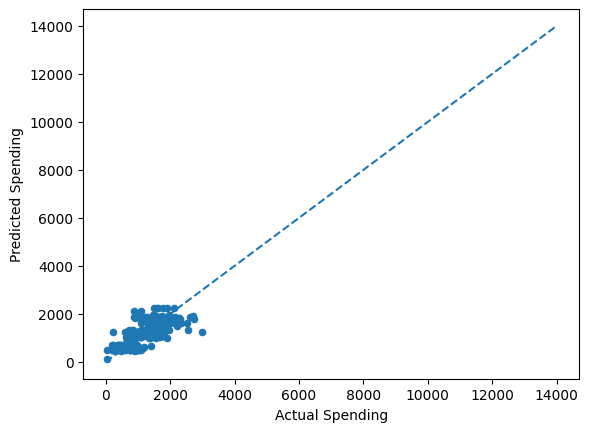

In [ ]:
# Plot actual and predicted
plt.scatter(y_test,y_pred,s=20)
plt.xlabel('Actual Spending')
plt.ylabel('Predicted Spending')

# Y = x reference line
plt.plot(range(0,15000,1000),range(0,15000,1000), ls='--')

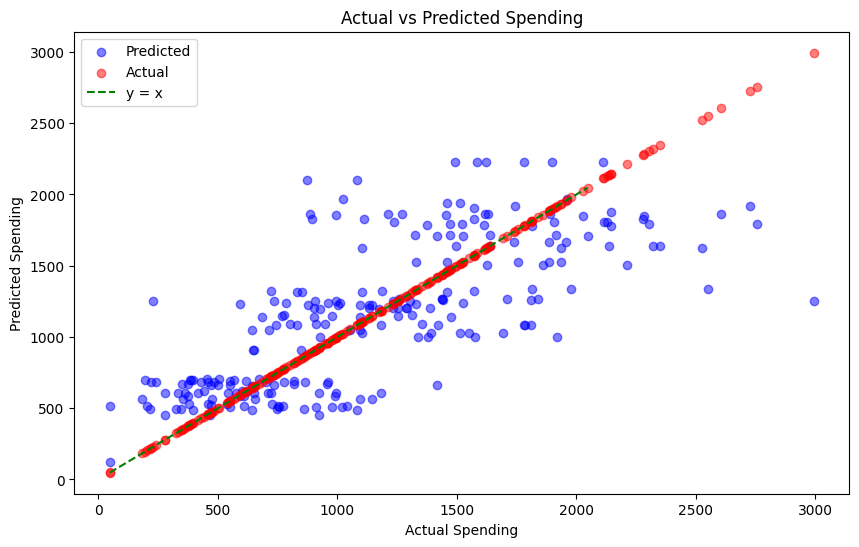

In [ ]:
# Another scatter plot for actual vs predicted with blue for Predicted and red for Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)

# Reference line for y = x
plt.plot(range(int(min(y_test)), int(max(y_test)), 1000), range(int(min(y_test)), int(max(y_test)), 1000), ls='--', color='green', label='y = x')

plt.xlabel('Actual Spending')
plt.ylabel('Predicted Spending')
plt.legend()
plt.title('Actual vs Predicted Spending')

plt.show()


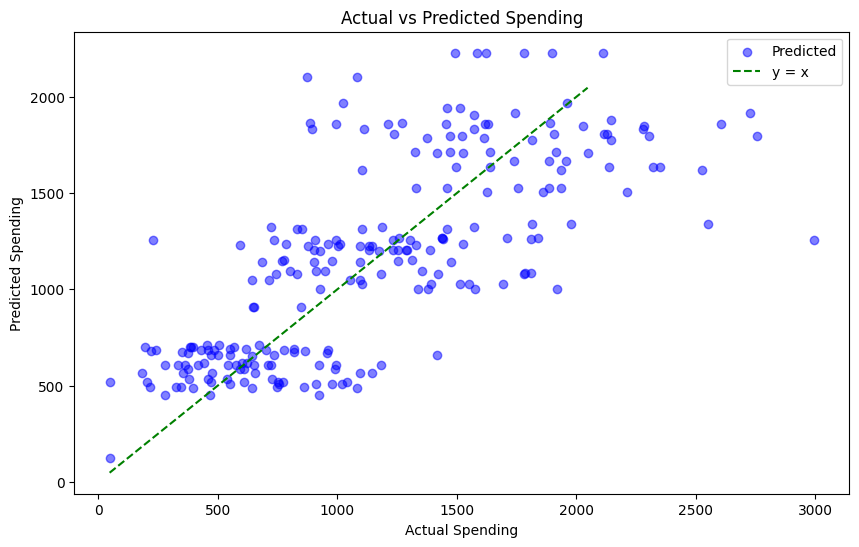

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)

# Reference line for y = x
plt.plot(range(int(min(y_test)), int(max(y_test)), 1000), range(int(min(y_test)), int(max(y_test)), 1000), ls='--', color='green', label='y = x')

plt.xlabel('Actual Spending')
plt.ylabel('Predicted Spending')
plt.legend()
plt.title('Actual vs Predicted Spending')

plt.show()


## 2. Predict using Logistic Regression
> Can we predict if the total spending category for Jan 2021 to Nov 2021 will exceed the spend requirement for a promo, given spending from selected categories?

Lets set the spend requirement as 3,000 USD


In [ ]:
# create total_amt_cat column
#total_df['total_amt_cat'] =  (total_df['total_amt']>3000).astype(int)
#total_df.head()

In [ ]:
# Declare input and target variables
#X = total_df[feature_cols]
#y = total_df['total_amt_cat']

In [ ]:
# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
# Check the length of train and test data set
#len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
# Initialize model
#model = LogisticRegression()

In [ ]:
# Fit the model to the training data
#model.fit(X_train, y_train)

In [ ]:
# Predict on the test data
#y_pred = model.predict(X_test)

In [ ]:
# Confusion matrix
#print("Confusion Matrix:")
#conf_matrix = confusion_matrix(y_test, y_pred)
#conf_matrix

In [ ]:
# Use heat map
#plt.figure(figsize=(4,4))
#sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['below reqts', 'met reqts'], yticklabels=['below reqts', 'met reqts'])
#plt.xlabel('Predicted labels')
#plt.ylabel('True labels')

In [ ]:
# Classification report
#print("Classification Report:")
#print(classification_report(y_test, y_pred))

## Taking it further

1. Explore [sampling correction methods](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/) for possible over/undersampled groups
2. Explore adding [regularization](https://www.analyticsvidhya.com/blog/2022/08/regularization-in-machine-learning/) options to model training. Regularization is a technique used in machine learning to prevent overfitting by adding a penalty term to the model's loss function, discouraging overly complex models. It helps to find a balance between fitting the training data well and generalizing to unseen data.
3. Explore removing outliers to improve accuracy.
4. Explore if scaling the variables improve performance.